# RQ2b1

In [2]:
import json
import os

In [3]:
def normalize_dict_values(results):
    categories = set()
    for lang in results:
        for model in results[lang]:
            categories.update(results[lang][model].keys())

    min_vals = {cat: float('inf') for cat in categories}
    max_vals = {cat: float('-inf') for cat in categories}

    for lang in results:
        for model in results[lang]:
            for cat in results[lang][model]:
                val = results[lang][model][cat]
                if val < min_vals[cat]:
                    min_vals[cat] = val
                if val > max_vals[cat]:
                    max_vals[cat] = val

    norm_results = {}
    for lang in results:
        norm_results[lang] = {}
        for model in results[lang]:
            norm_results[lang][model] = {}
            for cat in results[lang][model]:
                val = results[lang][model][cat]
                min_val = min_vals[cat]
                max_val = max_vals[cat]
                if max_val == min_val:
                    norm_val = 0.0  # or 1.0, or keep as is; here we set to 0.0
                else:
                    norm_val = (val - min_val) / (max_val - min_val)
                norm_results[lang][model][cat] = norm_val
    return norm_results

In [4]:
## MFQ
with open("/shared/2/projects/moral-project/ModelValues/Results/MFQ2_combined.json", "r") as f:
    mfq_results = json.load(f)
for lang in mfq_results:
    for model in mfq_results[lang]:
        equality = mfq_results[lang][model].get("equality", None)
        proportionality = mfq_results[lang][model].get("proportionality", None)
        if equality is not None and proportionality is not None:
            fairness = (equality + proportionality) / 2
            mfq_results[lang][model]["fairness"] = fairness
        mfq_results[lang][model].pop("equality", None)
        mfq_results[lang][model].pop("proportionality", None)

mfq_results = normalize_dict_values(mfq_results)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

avg_mfq_per_lang = {
    lang: {k: v / len(model_scores) for k, v in pd.DataFrame(model_scores).T.sum().items()}
    for lang, model_scores in mfq_results.items()
}

df = pd.DataFrame(avg_mfq_per_lang).T

df

,care,loyalty,authority,purity,fairness
German,0.876286,0.757143,0.752571,0.738000,0.711627
English,0.828571,0.695429,0.685429,0.695143,0.635249
Urdu,0.661714,0.595429,0.642857,0.609429,0.598168
Hindi,0.795143,0.752571,0.771143,0.823714,0.733934
Chinese,0.847429,0.757143,0.795429,0.671143,0.709115
Spanish,0.833143,0.799714,0.804857,0.700286,0.719013


In [ ]:
if df.empty:
    print("Error: No data to process")
    exit()

df_scaled = df
# (df - df.min()) / (df.max() - df.min())
# df_scaled

/tmp/ipykernel_606784/36368082.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


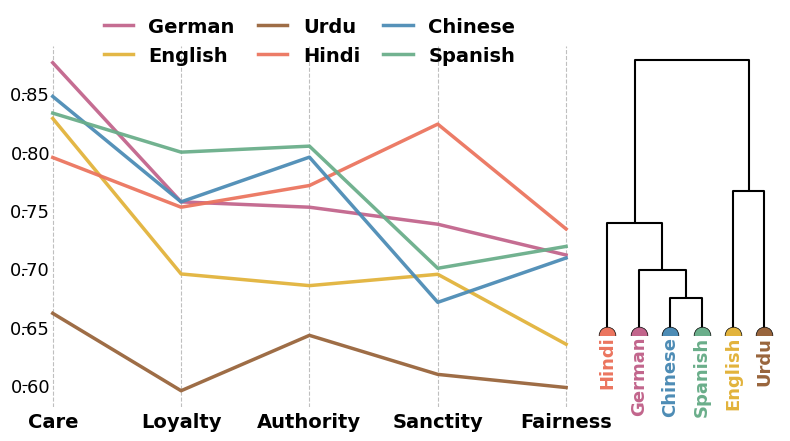

In [ ]:
languages_ordered = df_scaled.index.tolist()
df_ordered = df_scaled.copy()

import scipy.cluster.hierarchy as sch
from matplotlib import gridspec

fig = plt.figure(figsize=(8, 4.5), facecolor='white')
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 0.5], wspace=0.0)

ax = fig.add_subplot(gs[0])
ax.set_facecolor('white')

language_color_map = {
    'chinese': '#4D8CB5',
    'german':  '#C2658C',
    'hindi':   '#EB755F',
    'spanish': '#6AAE8A',
    'urdu':    '#99653C',
    'english': '#E2B33C'
}
language_color_map = {k.lower(): v for k, v in language_color_map.items()}

color_map = {}
for lang in languages_ordered:
    color_map[lang] = language_color_map.get(lang.lower(), '#000000')

for lang in languages_ordered:
    row = df_ordered.loc[lang]
    ax.plot(
        range(len(df.columns)), row, label=lang, color=color_map[lang], linewidth=2.5, alpha=0.95
    )

ax.set_ylabel("", fontsize=16, labelpad=0)
ax.set_xticks(range(len(df.columns)))
capitalized_labels = [
    "Sanctity" if label.lower() == "purity" else label.capitalize()
    for label in df.columns
]
ax.set_xticklabels(capitalized_labels, rotation=0, fontsize=14, fontweight='bold')
ax.tick_params(axis='y', labelsize=13, pad=-20)
ax.tick_params(axis='x', length=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(axis='x', which='major', linestyle='--', alpha=0.5, color='gray')

legend = ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.13),
    ncol=3,
    fontsize=14,
    frameon=False,
    handlelength=1.5,
    columnspacing=1.2
)
for text in legend.get_texts():
    text.set_fontweight('bold')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df_ordered.values)
linkage = sch.linkage(X, method='ward')

ax2 = fig.add_subplot(gs[1])
ax2.axis('off')

dendro_ax = inset_axes(
    ax2,
    width="100%",
    height="80%", 
    loc='center',
    bbox_to_anchor=(0, 0.1, 1, 1), 
    bbox_transform=ax2.transAxes,
    borderpad=0,
)

dendro = sch.dendrogram(
    linkage,
    labels=[lang.capitalize() for lang in df_ordered.index],
    orientation='top',
    ax=dendro_ax,
    color_threshold=0,
    above_threshold_color='black',
    leaf_font_size=13,
)

dendro_ax.set_xticklabels([])
dendro_ax.set_yticks([])
dendro_ax.set_ylabel("")
dendro_ax.set_xlabel("")

tick_positions = dendro_ax.get_xticks()
dendro_langs = dendro['ivl']
for xpos, lang in zip(tick_positions, dendro_langs):
    color = language_color_map.get(lang.lower(), '#000000')
    dendro_ax.plot(xpos, 0, 'o', color=color, markersize=12, markeredgecolor='k', markeredgewidth=0.5, zorder=10)
    dendro_ax.text(
        xpos, -0.02,
        lang,
        ha='center', va='top',
        rotation=90,
        color=color,
        fontsize=13,
        fontweight='bold',
        clip_on=False,
        zorder=11
    )
dendro_ax.set_xticklabels([])

for spine in dendro_ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("FinalPlots/parallel_coordinates_with_dendrogram.pdf", bbox_inches='tight')
plt.show()